In [73]:
import pandas as pd
import pickle
import datetime
import numpy as np
from collections import Counter
from itertools import chain 
import re
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns",5000)

In [49]:
def get_data_range(date_range=31):
    df = []
    for day in range(3, date_range+1):
        try:
            data = pd.read_parquet(f"../data_rr/vod_ldd_ecpm_daily_details_rr/year=2023/month=1/day={day}")
            df.append(data)
        except:
            print('path not exists',f"../data_rr/vod_ldd_ecpm_daily_details_rr/year=2023/month=1/day={day}")
    df = pd.concat(df)
    return df 

In [50]:
df1 = get_data_range()
df1.head()

,dnum,cid,columnsName,algo_type,baseCid,baseName,cidName,position,dateTime,pay_amt,producettype,frompagelevel1,vod_clk_cnt,sd_cpm,sd_income,col_algo_eps_pv,launcher_clk_cnt,income_filter,col_algo_cpm_filter,timestamp
0,547123399,LdmarQxVeh1642668150559,【下滑更多↓】猜你喜欢：一次看过瘾,replace,TjFdOvcZFC1670400470834,汽车世界之工程车好伙伴 第八季,汽车世界之工程车好伙伴 第五季,"{0,0}",2023-01-03 12:43:11,19.00,套餐,1.0,1,30.7443,19.0000,1043515,0,19.0,0.631999,2023-01-03 04:49:26
1,512533498,dJtprTbOtC1614159028243,【下滑更多↓】猜你喜欢：一次看过瘾,replace,ANEqaPBcyO1604037148198,汽车世界之玩具车总动员,汽车世界之玩具车总动员第三季,"{0,0}",2023-01-03 20:06:38,19.00,套餐,1.0,2,148.4375,19.0000,1043515,0,19.0,0.631999,2023-01-03 12:13:07
2,609366049,TjFdOvcZFC1670400470834,【下滑更多↓】猜你喜欢：一次看过瘾,replace,OZGFxJdCEA1604037148197,汽车世界之工程车好伙伴,汽车世界之工程车好伙伴 第八季,"{0,2}",2023-01-03 18:42:15,9.90,套餐,0.0,1,27.5000,9.9000,1043515,0,9.9,0.631999,2023-01-03 10:46:46
3,594676459,sTuXtscHGg1660283881528,【下滑更多↓】猜你喜欢：一次看过瘾,replace,dcFXccjtWN1670988679451,宝贝赳赳 第五季,宝贝赳赳 第四季,"{0,1}",2023-01-03 07:34:59,19.00,套餐,1.0,1,7.7997,19.0000,1043515,0,19.0,0.631999,2023-01-02 23:43:00
4,594778498,CCTCLxMrbY1612921864880,【下滑更多↓】猜你喜欢：一次看过瘾,replace,nmyUqVpBlr1614164299502,汪汪队立大功全集,汪汪队立大功 第2季,"{0,2}",2023-01-03 15:48:38,19.00,套餐,1.0,1,24.2656,19.0000,1043515,0,19.0,0.631999,2023-01-03 12:08:54


In [51]:
media = pd.read_parquet("../data_rr/doubaninfo_detail_merged_rr_v2")
ldd = media[(media.channel_name=='少儿')&(media.operate_status=='1' )]
ldd = ldd[ldd.vendor_list.apply(lambda x:"310" in x)]
df = df1.merge(ldd, left_on='cid', right_on='aid', how='left').drop('aid', axis=1)
df.head(1)

,dnum,cid,columnsName,algo_type,baseCid,baseName,cidName,position,dateTime,pay_amt,producettype,frompagelevel1,vod_clk_cnt,sd_cpm,sd_income,col_algo_eps_pv,launcher_clk_cnt,income_filter,col_algo_cpm_filter,timestamp,title,channel_name,vendor_list,quality,is_pay,nation,year,types,summarys,directors,score,language,doubanrecommendations,doubanduration,operate_status,content_type,tags,actors,age_min,age_max
0,547123399,LdmarQxVeh1642668150559,【下滑更多↓】猜你喜欢：一次看过瘾,replace,TjFdOvcZFC1670400470834,汽车世界之工程车好伙伴 第八季,汽车世界之工程车好伙伴 第五季,"{0,0}",2023-01-03 12:43:11,19.00,套餐,1.0,1,30.7443,19.0000,1043515,0,19.0,0.631999,2023-01-03 04:49:26,汽车世界之工程车好伙伴 第五季,少儿,[310],None,5,[],2021,[动画],[宝宝们最喜欢的工程车好伙伴们来了：挖掘机、压路机、翻斗车、搅拌机、起重车、推土机、拖拉机、...,[],8.0,[普通话],[],NaN,1,1,"[早教, 3至6岁]",None,3,7


###  How contents affect sd_income

In [58]:
# Group by 'cid' and compute the average sd_income for each unique content
avg_income_per_content = df.groupby('cid')['sd_income'].mean()
df['score'] = df['score'].astype('float64')
df['age_min'] = df['age_min'].astype('float64')
df['age_max'] = df['age_max'].astype('float64')
merged_df = df.drop('sd_income', axis=1).merge(avg_income_per_content, on='cid', how='left').drop_duplicates(subset='cid')
merged_df[['cid', 'sd_income']].head()

,cid,sd_income
0,LdmarQxVeh1642668150559,40.627273
1,dJtprTbOtC1614159028243,57.690000
2,TjFdOvcZFC1670400470834,29.328537
3,sTuXtscHGg1660283881528,26.819848
4,CCTCLxMrbY1612921864880,17.352571


#### content的数值特征影响 - score/ doubanduration/ age_min/ age_max 

In [59]:
feature_columns = df.columns[df.columns.get_loc('year')+1:].tolist()
numerical_features = merged_df[feature_columns].select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = merged_df[feature_columns].select_dtypes(exclude=['float64', 'int64']).columns.tolist()
numerical_features, categorical_features

(['score', 'doubanduration', 'age_min', 'age_max'],
 ['types',
  'summarys',
  'directors',
  'language',
  'doubanrecommendations',
  'operate_status',
  'content_type',
  'tags',
  'actors'])

In [60]:
correlations = merged_df[numerical_features + ['sd_income']].corr()['sd_income'].drop('sd_income')
correlations.sort_values(ascending=False)
# score: 0.0107 (very weak positive correlation) 极弱正相关
# age_min: -0.0304 (very weak negative correlation) 极弱负相关 - 不相关
# age_max: -0.0390 (very weak negative correlation) 极弱负相关 - 不相关
# doubanduration: -0.3637 (moderate negative correlation) 中等负相关

score             0.010709
age_min          -0.030390
age_max          -0.039045
doubanduration   -0.363749
Name: sd_income, dtype: float64

#### content的类别特征影响 - types/ language

/data/dev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


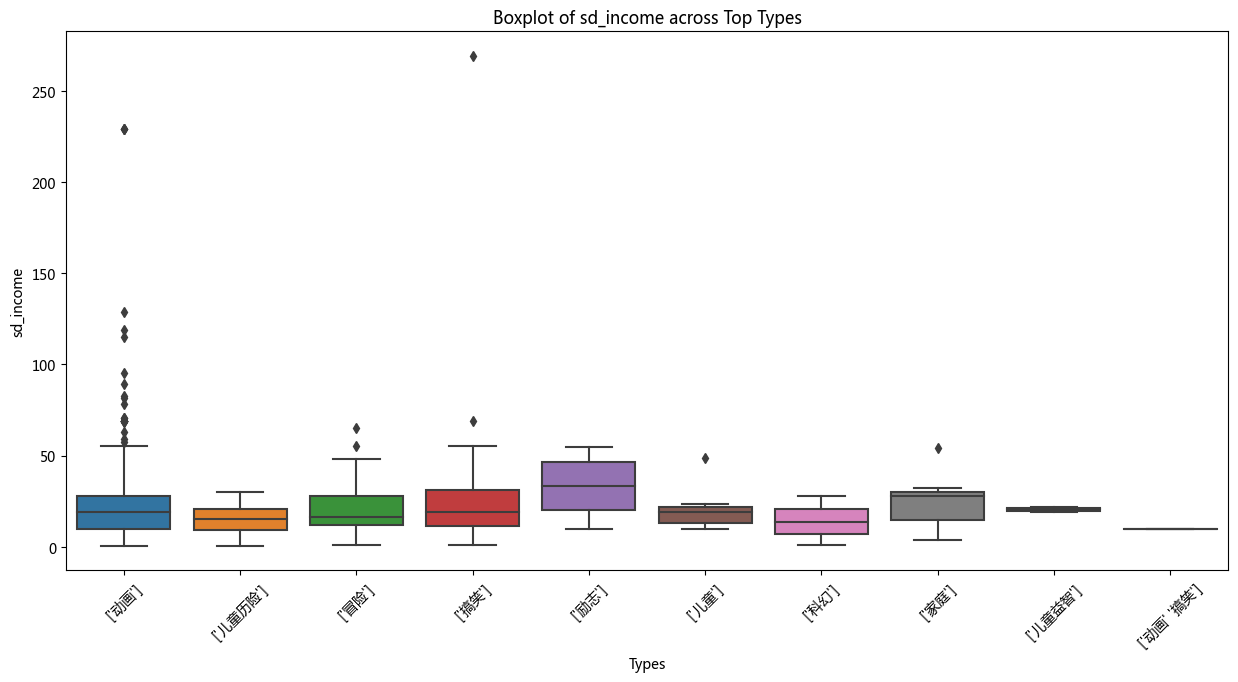

In [69]:
top_n = 10 # Number of top categories to visualize
top_types = merged_df['types'].value_counts().index[:top_n]
filtered_df = merged_df[merged_df['types'].isin(top_types)] # df on top10 types
filtered_df['types'] = filtered_df['types'].astype('str')
# Create boxplot
plt.figure(figsize=(15, 7))
sns.boxplot(data=filtered_df, x='types', y='sd_income')
plt.xticks(rotation=45)
plt.title('Boxplot of sd_income across Top Types')
plt.ylabel('sd_income')
plt.xlabel('Types')
plt.show()

In [77]:
df_trex = merged_df[(merged_df.algo_type=='trex')]
df_replace = merged_df[(merged_df.algo_type=='replace')]

/data/dev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


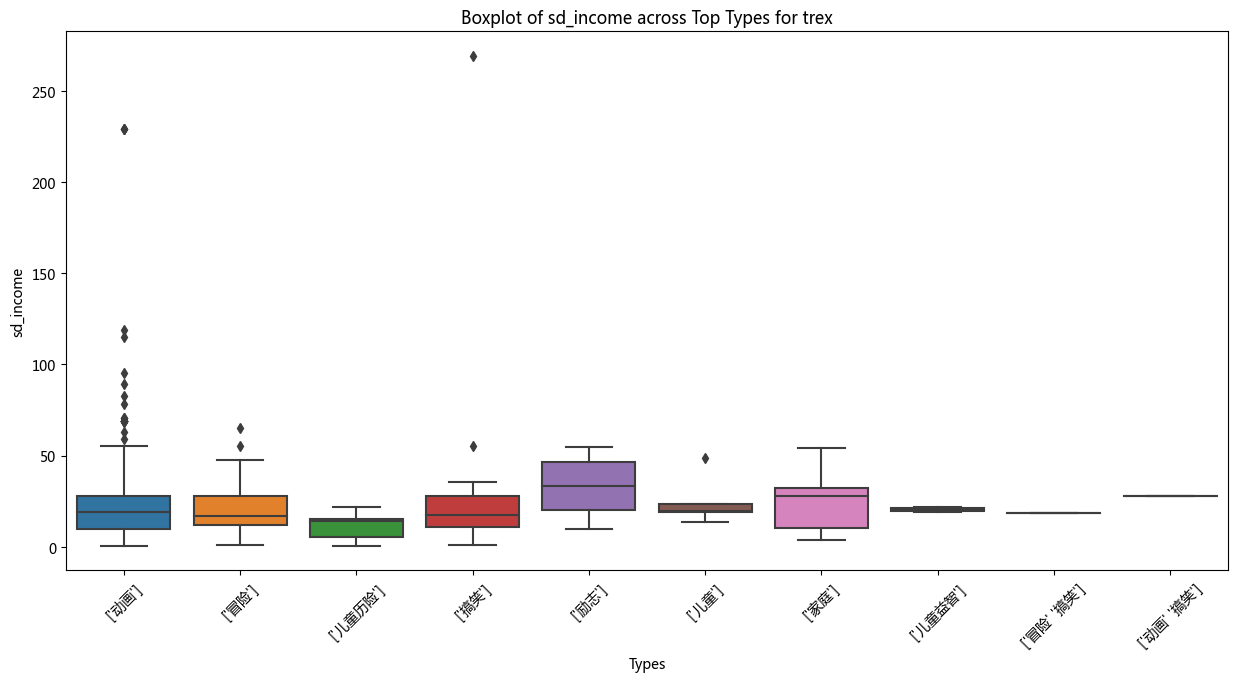

In [78]:
top_n = 10 # Number of top categories to visualize
top_types = df_trex['types'].value_counts().index[:top_n]
filtered_df_trex = df_trex[df_trex['types'].isin(top_types)] # df on top10 types
filtered_df_trex['types'] = filtered_df_trex['types'].astype('str')
# Create boxplot
plt.figure(figsize=(15, 7))
sns.boxplot(data=filtered_df_trex, x='types', y='sd_income')
plt.xticks(rotation=45)
plt.title('Boxplot of sd_income across Top Types for trex')
plt.ylabel('sd_income')
plt.xlabel('Types')
plt.show()

/data/dev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


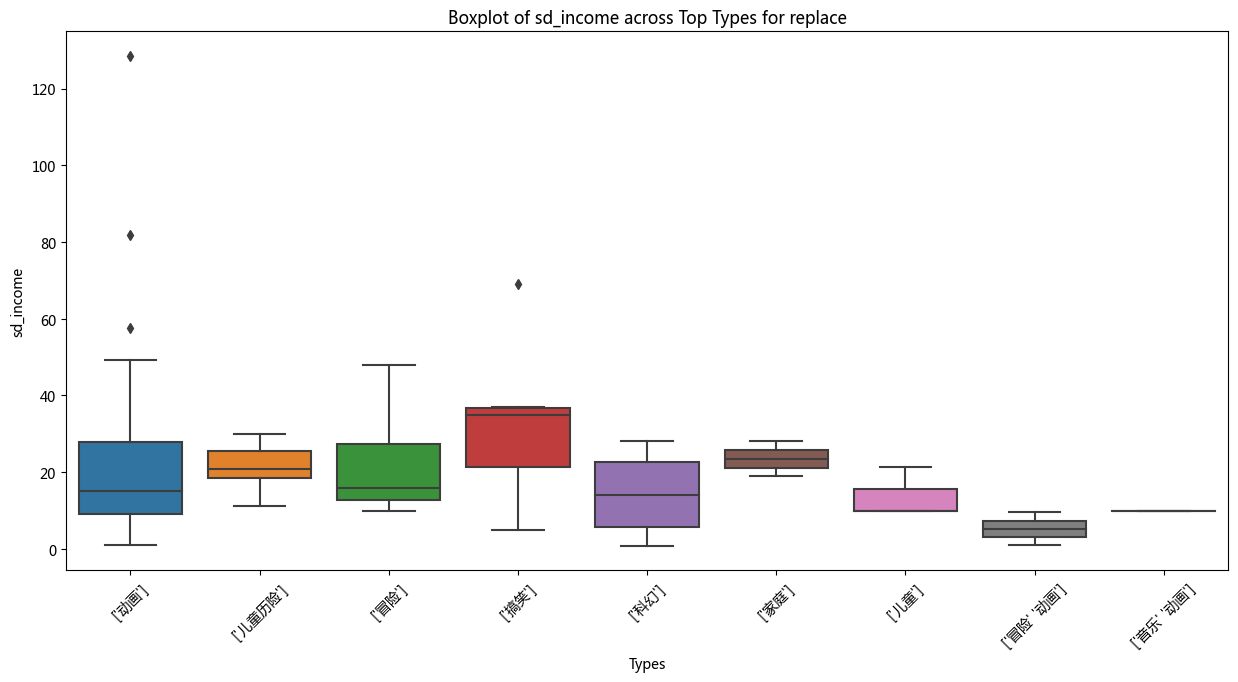

In [79]:
top_n = 10 # Number of top categories to visualize
top_types = df_replace['types'].value_counts().index[:top_n]
filtered_df_replace = df_replace[df_replace['types'].isin(top_types)] # df on top10 types
filtered_df_replace['types'] = filtered_df_replace['types'].astype('str')
# Create boxplot
plt.figure(figsize=(15, 7))
sns.boxplot(data=filtered_df_replace, x='types', y='sd_income')
plt.xticks(rotation=45)
plt.title('Boxplot of sd_income across Top Types for replace')
plt.ylabel('sd_income')
plt.xlabel('Types')
plt.show()

/data/dev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


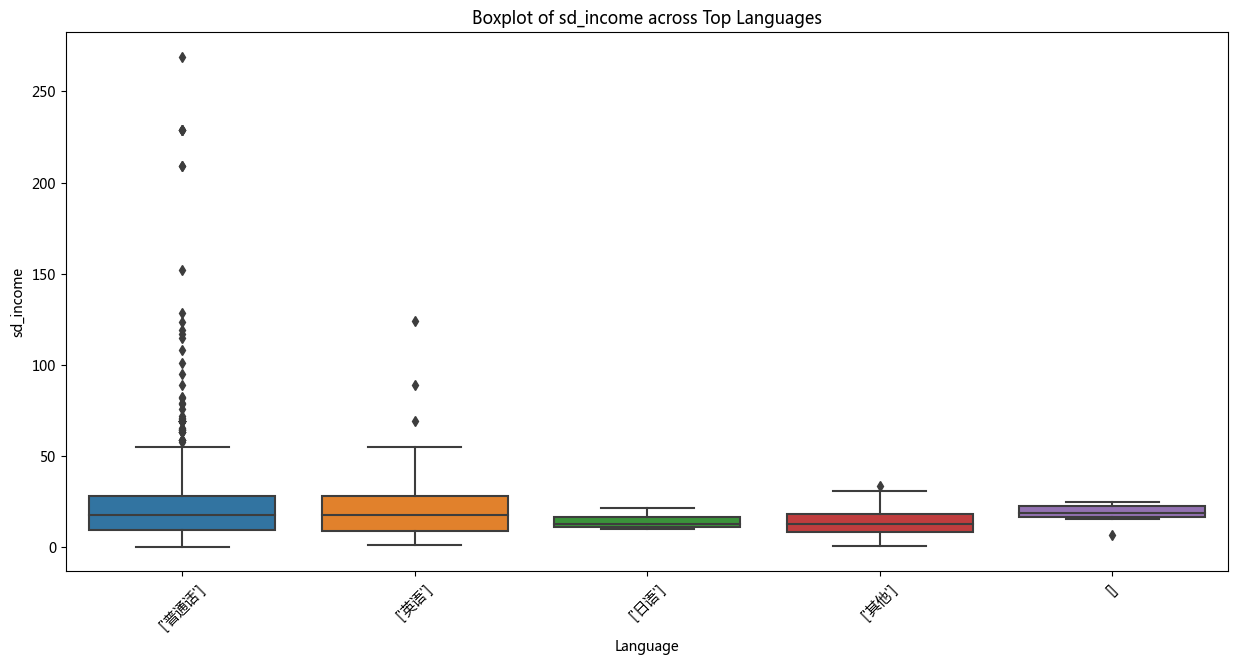

In [81]:
top_languages = merged_df['language'].value_counts().index[:top_n]
filtered_df_language = merged_df[merged_df['language'].isin(top_languages)]
filtered_df_language['language'] = filtered_df_language['language'].astype('str')
# Create boxplot for language
plt.figure(figsize=(15, 7))
sns.boxplot(data=filtered_df_language, x='language', y='sd_income')
plt.xticks(rotation=45)
plt.title('Boxplot of sd_income across Top Languages')
plt.ylabel('sd_income')
plt.xlabel('Language')
plt.show()

/data/dev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


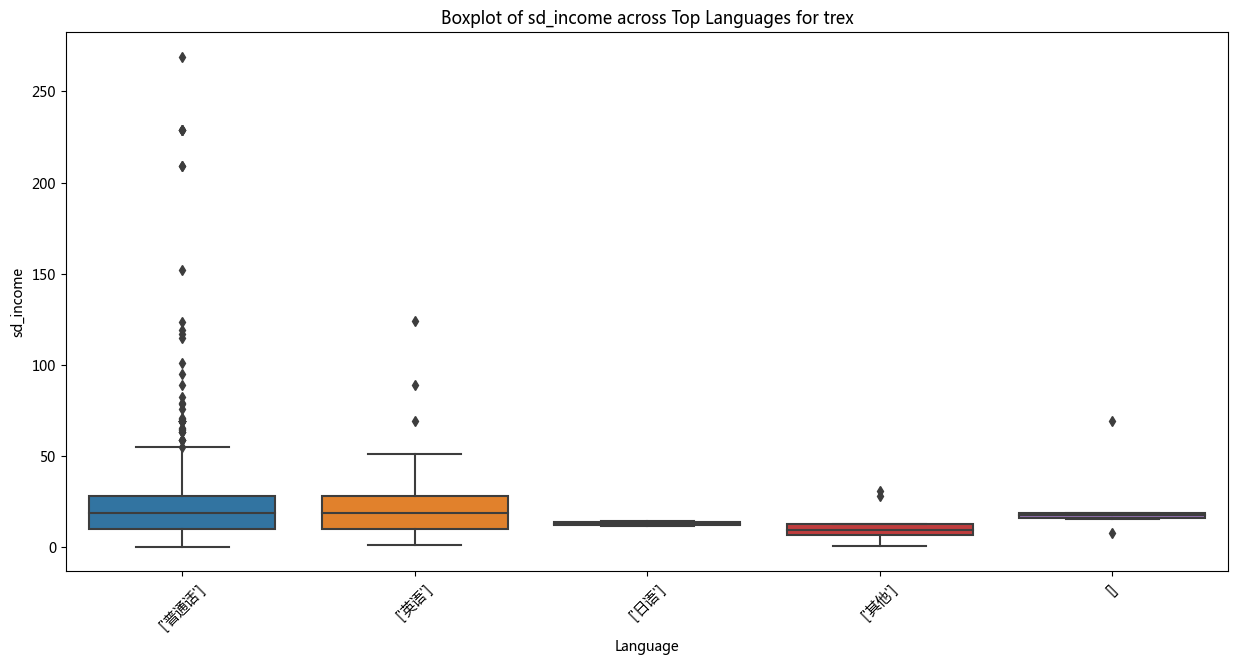

In [82]:
top_languages = df_trex['language'].value_counts().index[:top_n]
filtered_df_language_trex = df_trex[df_trex['language'].isin(top_languages)]
filtered_df_language_trex['language'] = filtered_df_language_trex['language'].astype('str')
# Create boxplot for language
plt.figure(figsize=(15, 7))
sns.boxplot(data=filtered_df_language_trex, x='language', y='sd_income')
plt.xticks(rotation=45)
plt.title('Boxplot of sd_income across Top Languages for trex')
plt.ylabel('sd_income')
plt.xlabel('Language')
plt.show()

/data/dev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


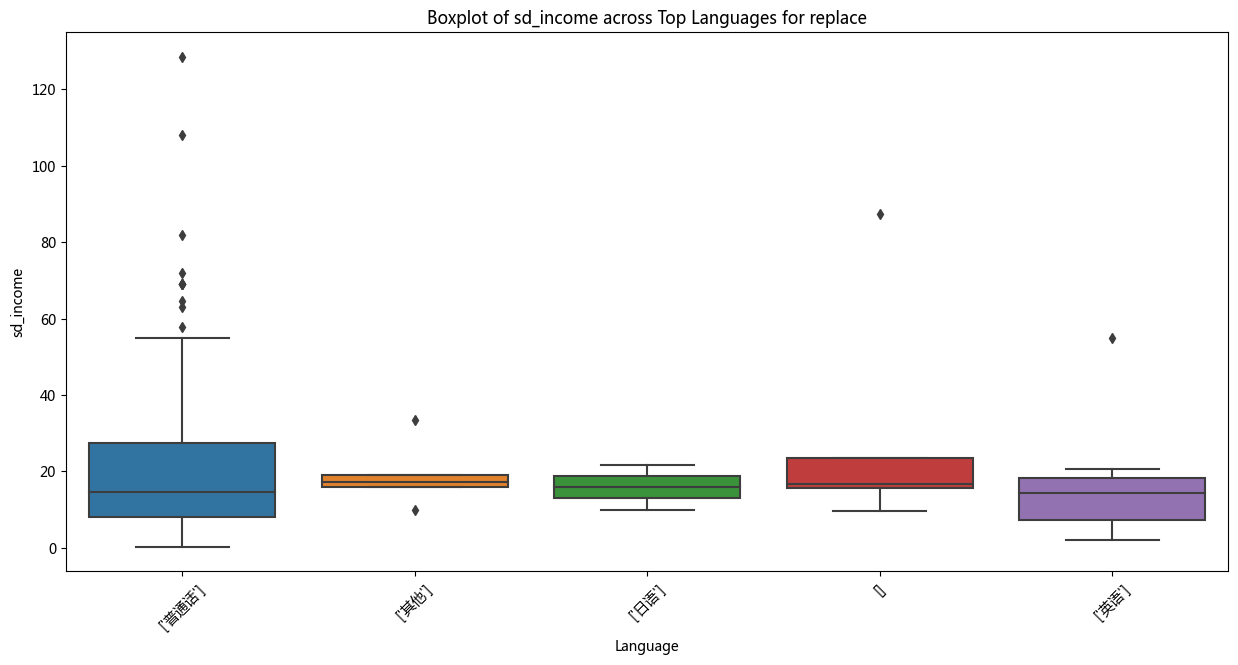

In [83]:
top_languages = df_replace['language'].value_counts().index[:top_n]
filtered_df_language_replace = df_replace[df_replace['language'].isin(top_languages)]
filtered_df_language_replace['language'] = filtered_df_language_replace['language'].astype('str')
# Create boxplot for language
plt.figure(figsize=(15, 7))
sns.boxplot(data=filtered_df_language_replace, x='language', y='sd_income')
plt.xticks(rotation=45)
plt.title('Boxplot of sd_income across Top Languages for replace')
plt.ylabel('sd_income')
plt.xlabel('Language')
plt.show()

In [71]:
# Check the number of observations for each of the top categories in 'types'
type_counts = filtered_df['types'].value_counts()
type_counts

['动画']         426
['冒险']          49
['搞笑']          29
['儿童历险']        15
['儿童']           8
['家庭']           7
['科幻']           5
['励志']           4
['儿童益智']         2
['动画' '搞笑']      1
Name: types, dtype: int64

In [85]:
filtered_df['language'] = filtered_df['language'].astype('str')
language_counts = filtered_df['language'].value_counts()
language_counts

/data/dev/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


['普通话']    518
['英语']      19
['其他']       8
[]           1
Name: language, dtype: int64

In [ ]:
# Remove rows with missing sd_income values from filtered datasets
filtered_df_cleaned = filtered_df.dropna(subset=['sd_income'])
filtered_df_language_cleaned = filtered_df_language.dropna(subset=['sd_income'])

# Perform ANOVA for 'types'
f_value_types_cleaned, p_value_types_cleaned = stats.f_oneway(*[filtered_df_cleaned['sd_income'][filtered_df_cleaned['types'] == t] for t in top_types])
f_value_types_cleaned, p_value_types_cleaned

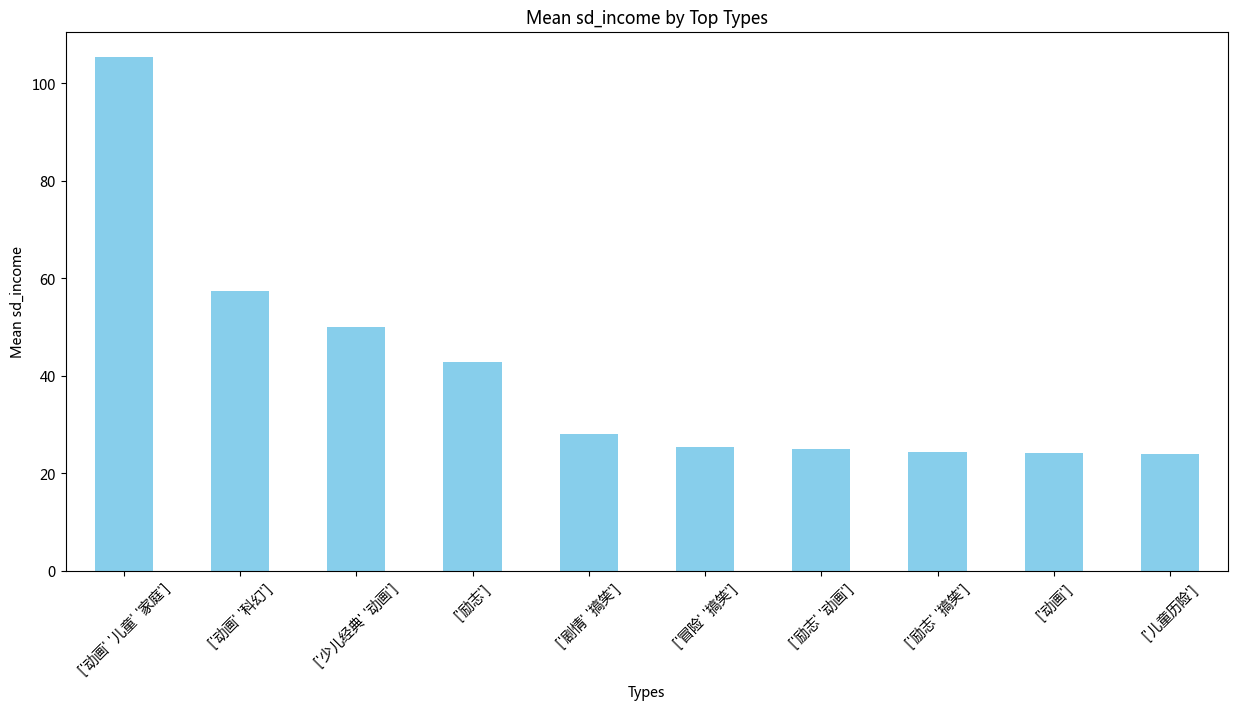

In [88]:
df['types'] = df['types'].astype('str')
mean_income_by_type = df.groupby('types')['sd_income'].mean().sort_values(ascending=False)
top_n = 10
top_types_mean_income = mean_income_by_type.head(top_n)
top_types_mean_income.plot(kind='bar', figsize=(15, 7), color='skyblue')
plt.title('Mean sd_income by Top Types')
plt.ylabel('Mean sd_income')
plt.xlabel('Types')
plt.xticks(rotation=45)
plt.show()

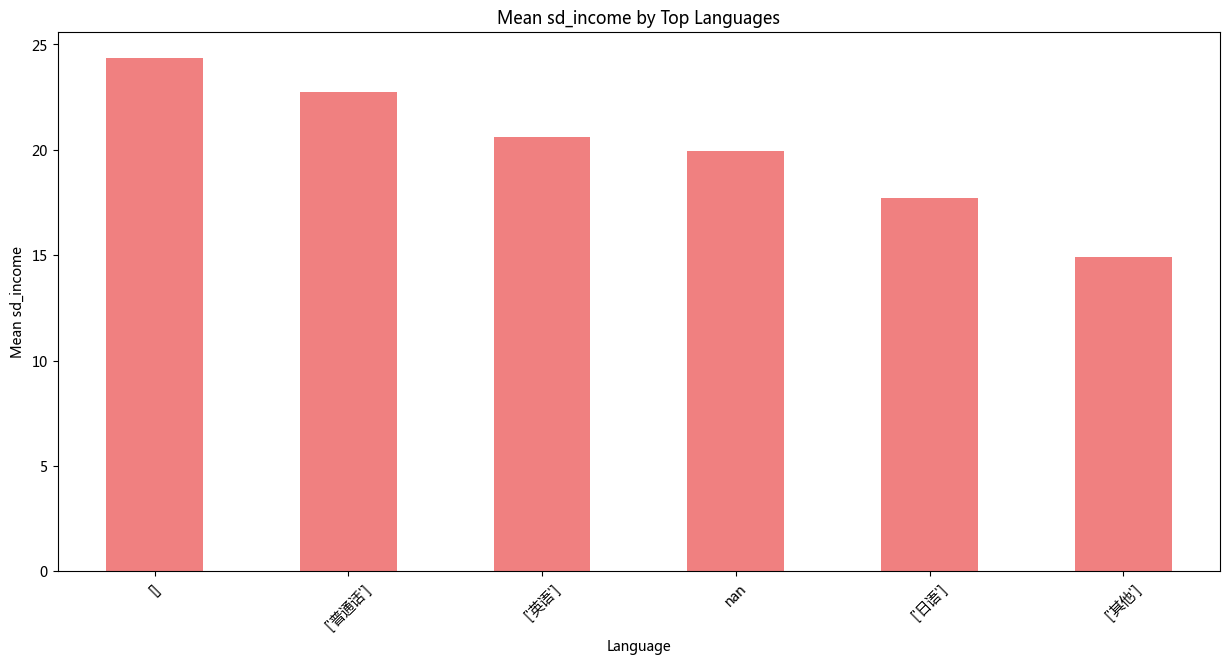

In [89]:
df['language'] = df['language'].astype('str')
mean_income_by_language = df.groupby('language')['sd_income'].mean().sort_values(ascending=False)
top_languages_mean_income = mean_income_by_language.head(top_n)
top_languages_mean_income.plot(kind='bar', figsize=(15, 7), color='lightcoral')
plt.title('Mean sd_income by Top Languages')
plt.ylabel('Mean sd_income')
plt.xlabel('Language')
plt.xticks(rotation=45)
plt.show()


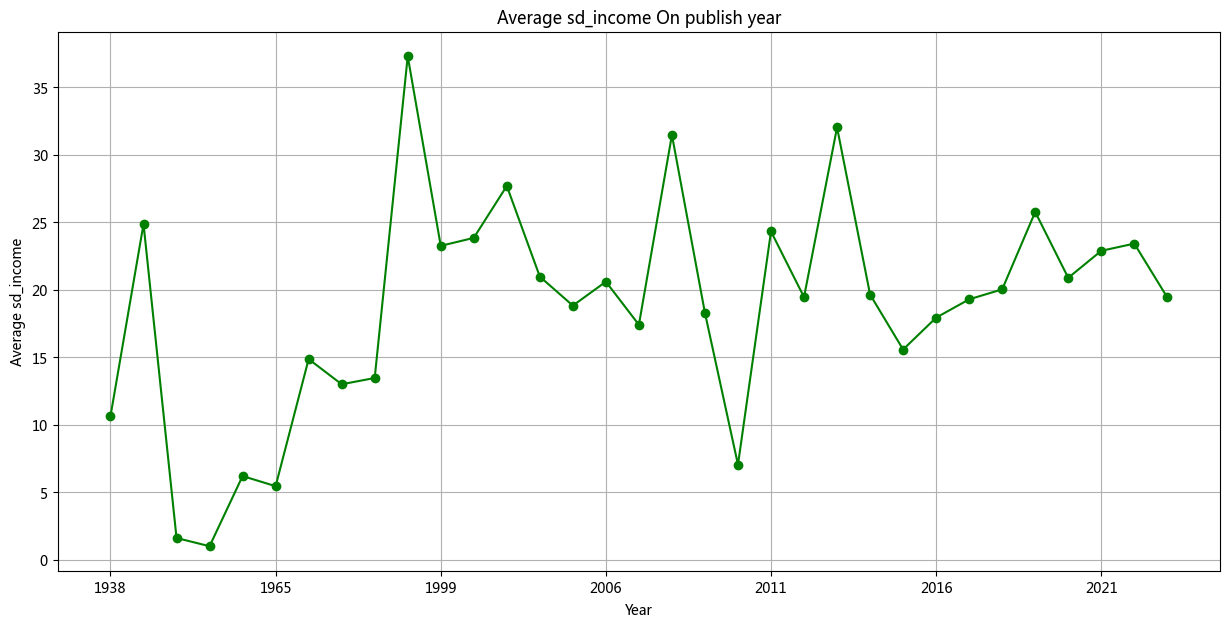

In [92]:
# Group by 'year' and compute the average sd_income
avg_income_per_year = df.groupby('year')['sd_income'].mean()
plt.figure(figsize=(15, 7))
avg_income_per_year.plot(kind='line', marker='o', color='green')
plt.title('Average sd_income On publish year')
plt.ylabel('Average sd_income')
plt.xlabel('Year')
plt.grid(True)
plt.show()

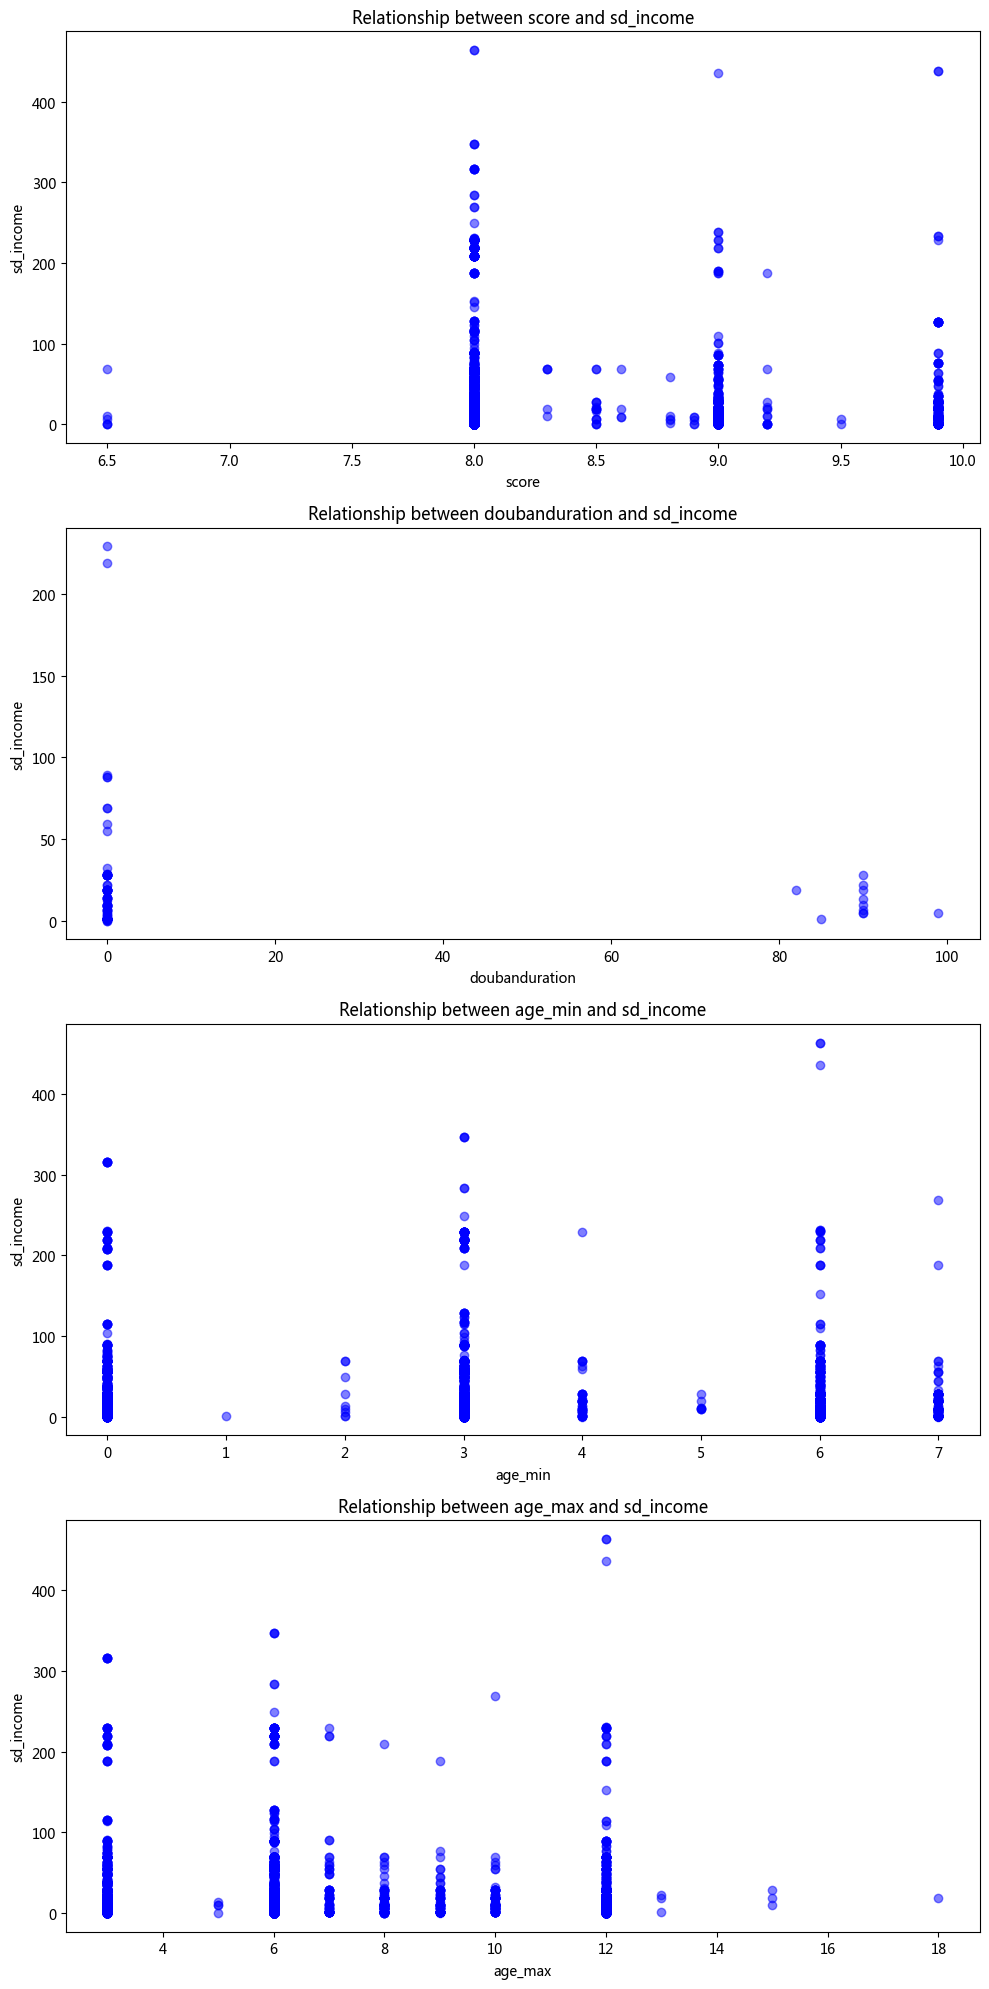

In [100]:
fig, axes = plt.subplots(nrows=len(numerical_features), ncols=1, figsize=(10, 5 * len(numerical_features)))
# Plot scatter plots for each numerical feature
for i, feature in enumerate(numerical_features):
    axes[i].scatter(df[feature], df['sd_income'], alpha=0.5, color='blue')
    axes[i].set_title(f'Relationship between {feature} and sd_income')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('sd_income')
plt.tight_layout()
plt.show()

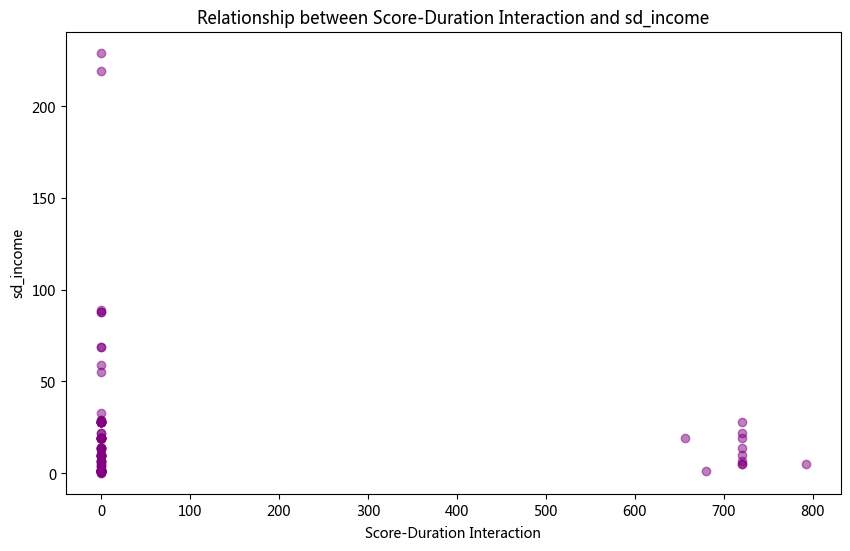

AttributeError: 'float' object has no attribute 'shape'

In [102]:
# Create interaction feature between 'score' and 'doubanduration'
df['score_duration_interaction'] = df['score'] * df['doubanduration']

# Visualize the relationship between the interaction feature and 'sd_income'
plt.figure(figsize=(10, 6))
plt.scatter(df['score_duration_interaction'], df['sd_income'], alpha=0.5, color='purple')
plt.title('Relationship between Score-Duration Interaction and sd_income')
plt.xlabel('Score-Duration Interaction')
plt.ylabel('sd_income')
plt.show()

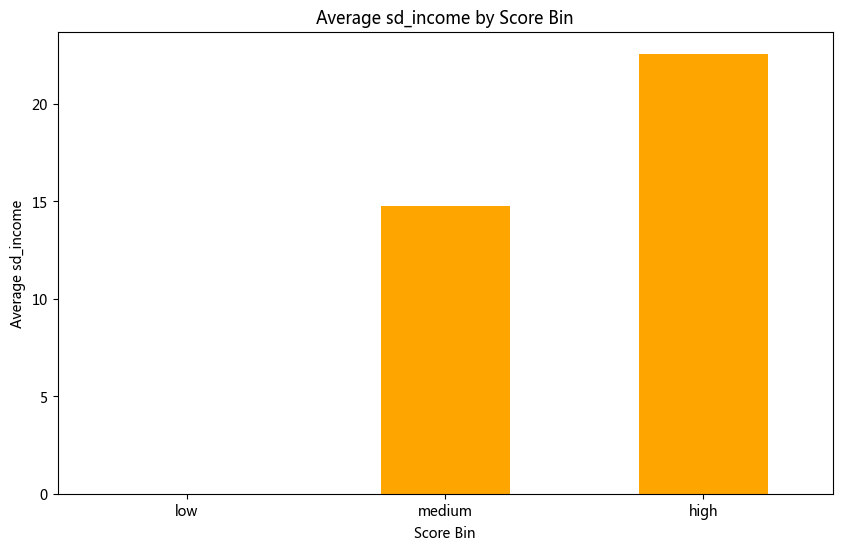

In [103]:
# Binning the 'score' feature
bins = [0, 6, 8, 10]
labels = ['low', 'medium', 'high']
df['score_bin'] = pd.cut(df['score'], bins=bins, labels=labels, right=False)
# Compute average 'sd_income' for each bin
avg_income_by_score_bin = df.groupby('score_bin')['sd_income'].mean()
# Visualize using bar plot
avg_income_by_score_bin.plot(kind='bar', figsize=(10, 6), color='orange')
plt.title('Average sd_income by Score Bin')
plt.ylabel('Average sd_income')
plt.xlabel('Score Bin')
plt.xticks(rotation=0)
plt.show()